<a href="https://colab.research.google.com/github/Ruban-31/test-repo/blob/main/SVM_pySpark_ET2_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CARDIOVASCULAR DISEASE PREDICTION USING ML WITH PySpark

Furkan Mistry - 2309032

Ruban Sivan Perumal - 2309011

Aryan Lalka - 2309002

## **About Dataset**

The published dataset  (**cardio_train.csv**) has 12 features meaning and types can be listed as follows :


| Column | Description |
| ------ | ----------- |
| age | Age (int)|
| height | Height (int) |
| weight | Weight (float) |
| gender | Gender (categorical code )|
| ap_hi | Systolic blood pressure (int) |
| ap_lo | Diastolic blood pressure (int) |
| cholesterol | Cholesterol (1:normal, 2: above normal, 3: well above normal) |
| gluc | Glucose (1:normal, 2: above normal, 3: well above normal) |
| smoke | Smoking (binary) |
| alco | Alcohol intake (binary) |
| active | Physical activity (binary) |
| cardio | Presence or absence of cardiovascular disease (binary) |


---


Our data has three thypes of data: **Quantitative data**, **Categorical data** and **Binary data**

In [ ]:
!pip install pandas numpy matplotlib scikit-learn seaborn

**Reading in the raw data set.**

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=db7829a00c2586a545d6b1ab0c4dc83d6b5c76812e5b1dfbfa0453d676bb659a
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [ ]:
import pandas as pd
import numpy as np

import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import LinearSVC

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, isnan
from pyspark.ml.feature import StandardScaler, MinMaxScaler
from pyspark.ml.linalg import Vectors

# Initialize Spark session
spark = SparkSession.builder.appName("cardio_train").getOrCreate()

# Load the dataset into a PySpark DataFrame
cardio = spark.read.csv("cardio_train.csv", header=True, inferSchema=True, sep=';')



In [ ]:
cardio.show()

+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
| id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|  0|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|
|  1|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|
|  2|18857|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|
|  3|17623|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|
|  4|17474|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|
|  8|21914|     1|   151|  67.0|  120|   80|          2|   2|    0|   0|     0|     0|
|  9|22113|     1|   157|  93.0|  130|   80|          3|   1|    0|   0|     1|     0|
| 12|22584|     2|   178|  95.0|  130|   90|          3|   3|    0|   0|     1|     1|
| 13|17668|     1|   158|  71.0|  110|   70

# 1 - Data Preprocessing and Exploratory Data Analysis <a class="anchor"  id="bir"></a>

In [ ]:
# Count missing values (null or NaN) for each column and sum them across the dataframe
from pyspark.sql.functions import sum as spark_sum


# Count missing values for each column
missing_values_per_column = cardio.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in cardio.columns])

# Total number of entries
num_entries = cardio.count() * len(cardio.columns)
print('Number of entries in the dataframe:', num_entries)

# Sum the missing values across all columns
num_missing_values = missing_values_per_column.select([spark_sum(c) for c in cardio.columns]).collect()[0][0]
print('Missing values:', num_missing_values)

# Count duplicate rows
cardio_dup = cardio.dropDuplicates().count()
if cardio_dup < cardio.count():
    print(f'Duplicates Rows in Dataset are: {cardio.count() - cardio_dup}')
else:
    print('Dataset contains no Duplicate Values')



Number of entries in the dataframe: 910000
Missing values: 0
Dataset contains no Duplicate Values


In [ ]:
cardio.describe()

DataFrame[summary: string, id: string, age: string, gender: string, height: string, weight: string, ap_hi: string, ap_lo: string, cholesterol: string, gluc: string, smoke: string, alco: string, active: string, cardio: string]

**Observations**
- 'Age' column has to be recalculated it has a minimum values of 10789' which is unrealistic therefore they represents a missing/incorrect value.
- 'Weight' column have unrealistic min/max values.
- Systolic blood pressure "ap_hi" and Diastolic blood pressure "ap_lo" cannot be negative
- If ap_hi and ap_lo are more than 180 and 120 mmHg respectively then it is an hypertensive crisis, which is an emergency case. Therefore max values are not realistic.



In [ ]:
#Age is written in days, so we're converting it to years
# Convert age from days to years
cardio = cardio.withColumn("age", col("age") / 365)

## 1.1 - Outlier detection - ap_hi, ap_lo <a class="anchor"  id="outlierdetection"></a>

According the figure below we can assume values larger than *280* mm Hg and *120* mm Hg for ap_hi and ap_lo respectively will be dropped as outliers. As well as negative values because they can not be negative.

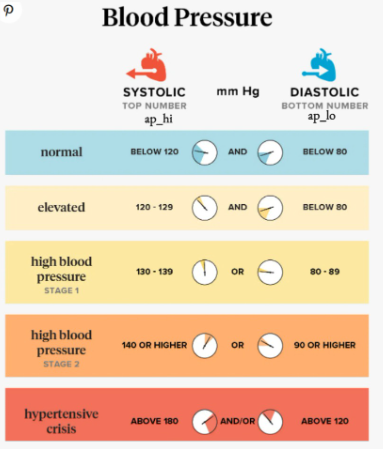

In [ ]:
# Count outliers for blood pressure (ap_hi and ap_lo)
outliers = cardio.filter((col("ap_hi") >= 280) | (col("ap_lo") >= 220) | (col("ap_lo") < 0) | (col("ap_hi") < 0) | (col("ap_hi") < col("ap_lo"))).count()
print(f'We have total {outliers} outliers')
print(f'Percent outliers: {round(outliers / cardio.count() * 100, 1)}%')

We have total 1275 outliers
Percent outliers: 1.8%


### Filtering out the unrealistic data of Systolic blood pressure and Diastolic blood pressure

In [ ]:
#Filtering out the unrealistic data of Systolic blood pressure and Diastolic blood pressure
cardio = cardio.filter((col("ap_lo") >= 0) & (col("ap_hi") >= 0) & (col("ap_lo") <= 220) & (col("ap_hi") <= 280) & (col("ap_hi") > col("ap_lo")))

In [ ]:
# Define a function to apply IQR filtering
def filter_iqr(df, column, q_low, q_high):
    Q1 = df.approxQuantile(column, [q_low], 0.01)[0]
    Q3 = df.approxQuantile(column, [q_high], 0.01)[0]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

# Apply IQR filtering for ap_hi and ap_lo
cardio = filter_iqr(cardio, "ap_hi", 0.05, 0.95)
cardio = filter_iqr(cardio, "ap_lo", 0.05, 0.95)


## 1.2 - IQR based filtering - height, weight <a class="anchor"  id="iqr"></a>

Good for skewed data distributions. We can observe lot's of outliers (points below lower fence and above upper fence)





In [ ]:
#Filtering out the smallest and tallest human ever known were 54 cm and 251 cm respectively so
cardio = cardio.filter((col("height") >= 54) & (col("height") <= 251))

In [ ]:
# Detect outliers in height and weight based on IQR
def detect_outliers(df, col1, col2, q1, q3):
    for col_name in [col1, col2]:
        Q1 = df.approxQuantile(col_name, [q1], 0.01)[0]
        Q3 = df.approxQuantile(col_name, [q3], 0.01)[0]
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df.filter((col(col_name) < lower_bound) | (col(col_name) > upper_bound)).count()
        print(f'Feature: {col_name} | Outliers: {outliers}')

detect_outliers(cardio, 'height', 'weight', 0.05, 0.95)


Feature: height | Outliers: 46
Feature: weight | Outliers: 24


## 1.3 - BMI - filtering <a class="anchor"  id="bmi"></a>

we can create new feature BMI (Body Mass Index) with height and weight. It might lead us to get better insights. The BMI says whether the person is in normal health or not . To calcualte it we have a formula

\begin{equation}
BMI = \tfrac{weight}{height^2}
\end{equation}

*BMI = kg/m2 where kg is a person's weight in kilograms and m2 is their height in metres squared*

In [ ]:
# Calculating BMI
cardio = cardio.withColumn("BMI", col("weight") / (col("height") / 100) ** 2)
cardio.show(5)
# Filter out extreme BMI values
cardio_cleaned = cardio.filter((col("BMI") >= 10) & (col("BMI") <= 60))

+---+------------------+------+------+------+-----+-----+-----------+----+-----+----+------+------+------------------+
| id|               age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|               BMI|
+---+------------------+------+------+------+-----+-----+-----------+----+-----+----+------+------+------------------+
|  0|50.391780821917806|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|  21.9671201814059|
|  1| 55.41917808219178|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|34.927679158448385|
|  2| 51.66301369863014|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|23.507805325987146|
|  3| 48.28219178082192|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1| 28.71047932495361|
|  4| 47.87397260273973|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|23.011176857330703|
+---+------------------+------+------+------+---

In [ ]:
# Final dataset after processing
print(f'Number of rows of cardio dataset after data preprocessing: {cardio_cleaned.count()}')


Number of rows of cardio dataset after data preprocessing: 68598




---



**Feature Scaling**

- It is crucial for distance based models (KNN, SVM..etc), standardization is performed to prevent features with wider ranges from dominating the distance metric and hence take a lot of time to compute.

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

# Columns to be scaled
columns_to_scale = ['age', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gender', 'BMI', 'height']

# Vectorize the features
assembler = VectorAssembler(inputCols=columns_to_scale, outputCol="features")
vectorized_data = assembler.transform(cardio_cleaned)

# Apply StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(vectorized_data)
scaled_data = scaler_model.transform(vectorized_data)

scaled_data.select("scaled_features").show(5)


+--------------------+
|     scaled_features|
+--------------------+
|[-0.4340344605634...|
|[0.30948080825684...|
|[-0.2460284198372...|
|[-0.7460272436651...|
|[-0.8063998731224...|
+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import MinMaxScaler

# Apply MinMaxScaler
min_max_scaler = MinMaxScaler(inputCol="features", outputCol="minmax_features")
minmax_model = min_max_scaler.fit(vectorized_data)
scaled_data_mm = minmax_model.transform(vectorized_data)

scaled_data_mm.select("minmax_features").show(5)


+--------------------+
|     minmax_features|
+--------------------+
|[0.58807588075880...|
|[0.73015873015873...|
|[0.62400309717382...|
|[0.52845528455284...|
|[0.51691831204026...|
+--------------------+
only showing top 5 rows





---


**Train test split**

Here we will use the most common split ratio 80:20. That means 80% of the dataset goes into the training set and 20% of the dataset goes into the testing set

In [ ]:
from pyspark.ml.feature import VectorAssembler

# Columns to be used for assembling features
columns_to_scale = ['age', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gender', 'BMI', 'height']

# Prepare data for model training by creating feature vectors
assembler = VectorAssembler(inputCols=columns_to_scale, outputCol='features')

# Apply VectorAssembler to non-scaled data
assembler = VectorAssembler(inputCols=columns_to_scale, outputCol='features')
cardio_cleaned_assembled = assembler.transform(cardio_cleaned)

# Split the data into train and test sets for non-scaled data
train_data_cleaned, test_data_cleaned = cardio_cleaned_assembled.randomSplit([0.8, 0.2], seed=42)
print(f'Non-Scaled Data - Training set size: {train_data_cleaned.count()}, Test set size: {test_data_cleaned.count()}')

# Apply VectorAssembler to standard scaled data with a different output column
assembler_scaled = VectorAssembler(inputCols=columns_to_scale, outputCol='features_scaled')
scaled_data_assembled = assembler_scaled.transform(scaled_data)
train_data_scaled, test_data_scaled = scaled_data_assembled.randomSplit([0.8, 0.2], seed=42)
print(f'Standard Scaled Data - Training set size: {train_data_scaled.count()}, Test set size: {test_data_scaled.count()}')

# Apply VectorAssembler to min-max scaled data with a different output column
assembler_scaled_mm = VectorAssembler(inputCols=columns_to_scale, outputCol='features_minmax')
scaled_data_mm_assembled = assembler_scaled_mm.transform(scaled_data_mm)
train_data_scaled_mm, test_data_scaled_mm = scaled_data_mm_assembled.randomSplit([0.8, 0.2], seed=42)
print(f'Min-Max Scaled Data - Training set size: {train_data_scaled_mm.count()}, Test set size: {test_data_scaled_mm.count()}')



Non-Scaled Data - Training set size: 54720, Test set size: 13878
Standard Scaled Data - Training set size: 54720, Test set size: 13878
Min-Max Scaled Data - Training set size: 54720, Test set size: 13878


# **Normal Execution(Without SPARK)**

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Load the dataset into a pandas DataFrame
cardio = pd.read_csv("cardio_train.csv", sep=';')

# Preprocessing: Convert age from days to years
cardio['age'] = cardio['age'] / 365

# Remove unrealistic blood pressure values
cardio = cardio[(cardio['ap_lo'] >= 0) & (cardio['ap_hi'] >= 0) &
                (cardio['ap_lo'] <= 220) & (cardio['ap_hi'] <= 280) &
                (cardio['ap_hi'] > cardio['ap_lo'])]

# Apply IQR filtering
def filter_iqr(df, column, q_low, q_high):
    Q1 = df[column].quantile(q_low)
    Q3 = df[column].quantile(q_high)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

cardio = filter_iqr(cardio, "ap_hi", 0.05, 0.95)
cardio = filter_iqr(cardio, "ap_lo", 0.05, 0.95)

# Remove extreme height values
cardio = cardio[(cardio['height'] >= 54) & (cardio['height'] <= 251)]

# Calculate BMI
cardio['BMI'] = cardio['weight'] / (cardio['height'] / 100) ** 2

# Filter out extreme BMI values
cardio = cardio[(cardio['BMI'] >= 10) & (cardio['BMI'] <= 60)]

# Prepare features and target variable
X = cardio.drop(['cardio'], axis=1)  # Features
y = cardio['cardio']  # Target feature

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=True)

# Initialize the SVM model
svm_model = SVC(kernel='linear', random_state=42)

# Measure the start time
start_time = time.time()

# Train the SVM model
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Measure the end time
end_time = time.time()

# Calculate the execution time
execution_time = end_time - start_time
print(f'Execution Time of SVM Model: {execution_time:.2f} seconds')

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of SVM Model: {accuracy:.4f}')


Execution Time of SVM Model: 154.46 seconds
Accuracy of SVM Model: 0.7285


# **Support Vector Classifier with PySpark**

In [ ]:
import time
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Function to train and evaluate SVM model
def train_and_evaluate_svm(train_data, test_data, data_type):
    print(f"Training and evaluating SVM model on {data_type} data...")

    # Prepare SVM model
    svm = LinearSVC(labelCol='cardio', featuresCol='features', maxIter=10)

    # Measure the start time
    start_time = time.time()

    # Train the SVM model
    svm_model = svm.fit(train_data)

    # Make predictions on the test set
    predictions_svm = svm_model.transform(test_data)

    # Measure the end time
    end_time = time.time()

    # Calculate the execution time
    execution_time = end_time - start_time
    print(f'Execution Time of SVM Model on {data_type} data: {execution_time:.2f} seconds')

    # Evaluate the SVM model predictions
    evaluator_accuracy = MulticlassClassificationEvaluator(labelCol='cardio', predictionCol='prediction', metricName='accuracy')
    accuracy_svm = evaluator_accuracy.evaluate(predictions_svm)

    evaluator_precision = MulticlassClassificationEvaluator(labelCol='cardio', predictionCol='prediction', metricName='weightedPrecision')
    precision_svm = evaluator_precision.evaluate(predictions_svm)

    evaluator_recall = MulticlassClassificationEvaluator(labelCol='cardio', predictionCol='prediction', metricName='weightedRecall')
    recall_svm = evaluator_recall.evaluate(predictions_svm)

    evaluator_f1 = MulticlassClassificationEvaluator(labelCol='cardio', predictionCol='prediction', metricName='f1')
    f1_svm = evaluator_f1.evaluate(predictions_svm)

    print(f'Accuracy of SVM Model on {data_type} data: {accuracy_svm:.4f}')
    print(f'Precision of SVM Model on {data_type} data: {precision_svm:.4f}')
    print(f'Recall of SVM Model on {data_type} data: {recall_svm:.4f}')
    print(f'F1 Score of SVM Model on {data_type} data: {f1_svm:.4f}')
    print("\n")

# Train and evaluate on non-scaled data
train_and_evaluate_svm(train_data_cleaned, test_data_cleaned, 'non-scaled')

# Train and evaluate on standard scaled data
train_and_evaluate_svm(train_data_scaled, test_data_scaled, 'standard scaled')

# Train and evaluate on min-max scaled data
train_and_evaluate_svm(train_data_scaled_mm, test_data_scaled_mm, 'min-max scaled')


Training and evaluating SVM model on non-scaled data...
Execution Time of SVM Model on non-scaled data: 8.37 seconds
Accuracy of SVM Model on non-scaled data: 0.7224
Precision of SVM Model on non-scaled data: 0.7299
Recall of SVM Model on non-scaled data: 0.7224
F1 Score of SVM Model on non-scaled data: 0.7199


Training and evaluating SVM model on standard scaled data...
Execution Time of SVM Model on standard scaled data: 6.19 seconds
Accuracy of SVM Model on standard scaled data: 0.7224
Precision of SVM Model on standard scaled data: 0.7299
Recall of SVM Model on standard scaled data: 0.7224
F1 Score of SVM Model on standard scaled data: 0.7199


Training and evaluating SVM model on min-max scaled data...
Execution Time of SVM Model on min-max scaled data: 4.35 seconds
Accuracy of SVM Model on min-max scaled data: 0.7224
Precision of SVM Model on min-max scaled data: 0.7299
Recall of SVM Model on min-max scaled data: 0.7224
F1 Score of SVM Model on min-max scaled data: 0.7199




## **Hypertuning**

In [ ]:
import time
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

# Define the SVM model with regularization parameter
svm = LinearSVC(labelCol='cardio', featuresCol='features_minmax')

# Define a smaller parameter grid for faster hyperparameter tuning
paramGrid = (ParamGridBuilder()
             .addGrid(svm.regParam, [0.1])  # Reduced regularization parameters
             .addGrid(svm.maxIter, [50])    # Reduced number of iterations
             .build())

# Define the evaluator
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol='cardio', predictionCol='prediction', metricName='accuracy')

# Define cross-validation with fewer folds
crossval = CrossValidator(estimator=svm,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator_accuracy,
                          numFolds=2,  # Reduced number of folds
                          parallelism=4)  # Ensure this matches your cluster capacity

# Function to train and evaluate SVM model
def train_and_evaluate_svm(train_data, test_data, data_type):
    print(f"Training and evaluating SVM model on {data_type} data...")

    # Measure the start time
    start_time = time.time()

    # Train the SVM model with cross-validation
    cv_model = crossval.fit(train_data)

    # Make predictions on the test set
    predictions_svm = cv_model.transform(test_data)

    # Measure the end time
    end_time = time.time()

    # Calculate the execution time
    execution_time = end_time - start_time
    print(f'Execution Time of SVM Model on {data_type} data: {execution_time:.2f} seconds')

    # Evaluate the SVM model predictions for accuracy
    accuracy_svm = evaluator_accuracy.evaluate(predictions_svm)

    print(f'Accuracy of SVM Model on {data_type} data: {accuracy_svm:.4f}')
    print("\n")

# Train and evaluate on min-max scaled data
train_and_evaluate_svm(train_data_scaled_mm, test_data_scaled_mm, 'min-max scaled')


Training and evaluating SVM model on min-max scaled data...
Execution Time of SVM Model on min-max scaled data: 17.13 seconds
Accuracy of SVM Model on min-max scaled data: 0.7219




As one can see pySpark execution is alot faster